In [26]:
import sys
sys.path.append("../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import pandas as pd
%matplotlib inline

plt.style.use(["science","bright"])
plt.rcParams['figure.dpi'] = 200

In [43]:
N   = 7
topology_parameter = {
    "Nx"                : N,
    "Ny"                : N,
    "Nz"                : 1,
    "e_pos"             : [[(N-1)//2,0,0],[0,0,0],[N-1,0,0],
                            [0,(N-1)//2,0],[N-1,(N-1)//2,0],[0,N-1,0],
                            [N-1,N-1,0],[(N-1)//2,N-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant','constant','constant','constant','floating']
}

sim_dic =   {
    "error_th"        : 0.05,      
    "max_jumps"       : 10000000,
    "eq_steps"        : 100000,
    "jumps_per_batch" : 5000,
    "kmc_counting"    : False,
    "min_batches"     : 5
}

In [44]:
N_data          = 100
voltages        = np.zeros(shape=(N_data,len(topology_parameter["e_pos"])+1))
x_vals          = np.linspace(0, 0.03, N_data, endpoint=False)
voltages[:,0]   = x_vals

In [45]:
sim_const   = nanonets.simulation(topology_parameter=topology_parameter)
sim_const.run_const_voltages(voltages=voltages, target_electrode=7, save_th=0.1, sim_dic=sim_dic)
df_const    = pd.DataFrame(sim_const.return_output_values())

Text(0.5, 0, 'Jumps per Simulation')

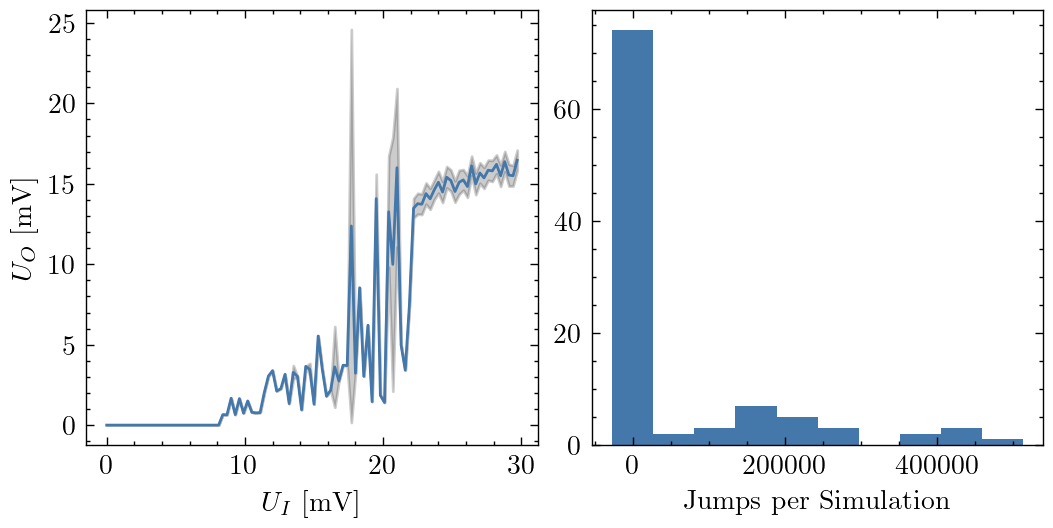

In [46]:
fig = plt.figure(layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot(1,2,1)
ax.plot(x_vals*1000, df_const[2]*1000)
ax.fill_between(x_vals*1000, df_const[2]*1000-df_const[3]*1000, df_const[2]*1000+df_const[3]*1000, color='black', alpha=0.2)

ax.set_xlabel('$U_I$ [mV]')
ax.set_ylabel('$U_O$ [mV]')

ax  = fig.add_subplot(1,2,2)
ax.hist(df_const[1], align='left')
ax.set_xlabel('Jumps per Simulation')

In [33]:
time_step   = 1e-4
time_steps  = np.arange(N_data)*time_step
sim_time    = nanonets.simulation(topology_parameter=topology_parameter)
sim_time.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=7, stat_size=10, save=False)
df_time    = pd.DataFrame(sim_time.return_output_values())

Text(0.5, 0, 'Jumps per Simulation')

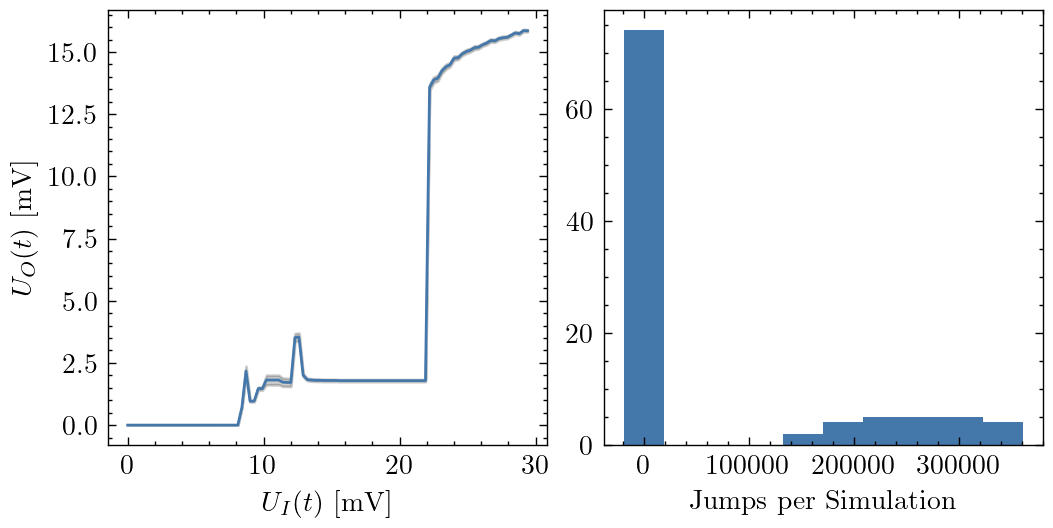

In [34]:
fig = plt.figure(layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot(1,2,1)
ax.plot(x_vals[:-1]*1000, df_time[2]*1000)
ax.fill_between(x_vals[:-1]*1000, df_time[2]*1000-df_time[3]*1000, df_time[2]*1000+df_time[3]*1000,
                color='black', alpha=0.2)
ax.set_xlabel('$U_I(t)$ [mV]')
ax.set_ylabel('$U_O(t)$ [mV]')

ax  = fig.add_subplot(1,2,2)
ax.hist(df_time[1], align='left')
ax.set_xlabel('Jumps per Simulation')